<a href="https://www.kaggle.com/code/ricardotangarife/two-class-urbansound8k-k-fold-cv-cnn2d?scriptVersionId=106513055" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Audio files and CSV file containing metadata
file_path = '../input/urbansound8k'
urbansound8k = pd.read_csv('../input/urbansound8k/UrbanSound8K.csv')
file_viz = glob.glob('../input/urbansound8k/fold1/*')

In [3]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
#Change dataset to get interest classes to classify
urbansound8k = urbansound8k.loc[((urbansound8k["class"]=="gun_shot") | (urbansound8k["class"]=="siren"))]
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
106,102305-6-0-0.wav,102305,0.0,2.61161,1,1,6,gun_shot
114,102853-8-0-0.wav,102853,0.0,4.00000,2,7,8,siren
115,102853-8-0-1.wav,102853,0.5,4.50000,2,7,8,siren
116,102853-8-0-2.wav,102853,1.0,5.00000,2,7,8,siren
117,102853-8-0-3.wav,102853,1.5,5.50000,2,7,8,siren


In [5]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
#Mapping classes to use
class_map = {'6' : 'gun_shot', '8' : 'siren',}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,6,gun_shot
1,8,siren


In [6]:
#Take samples of dataset to preview
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [7]:
#Function to get data from audio sampling to rate of 22050 by default.
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('gun_shot', (29327,)), ('siren', (88200,))]

In [8]:
#Show samples of data to be played.
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

gun_shot :


siren :


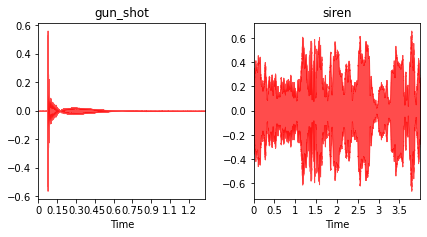

In [9]:
#Showing waveforms of taked samples
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

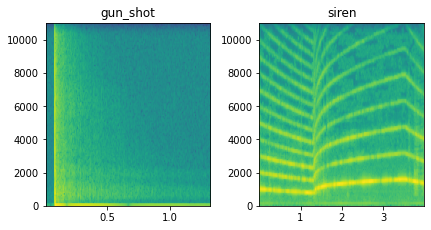

In [10]:
#Showing spectograms of taked samples
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

### Extracting features using Librosa

In [11]:
#Function to extract features with librosa, getting mel frequency cepstrals coeficient 
#Add pading to have same size of coeficients as input to model
max_pad_len = 174
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [12]:
features = []

# Iterate through each sound file and extract the features 
for index, row in urbansound8k.iterrows():
    
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["classID"]
    fold = row["fold"]
    data = extract_features(file_name)
    
    features.append([data, class_label, fold])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label', 'fold'])

In [13]:
featuresdf.head()

,feature,class_label,fold
0,"[[-119.95263, -98.58099, -102.46894, -113.9573...",6,1
1,"[[-212.37451, -203.63791, -200.84283, -208.838...",8,7
2,"[[-196.08969, -200.47655, -211.0078, -213.0787...",8,7
3,"[[-187.98851, -198.36465, -217.52213, -221.166...",8,7
4,"[[-224.6572, -225.77936, -235.45703, -238.4739...",8,7


In [14]:
featuresdf2 = pd.DataFrame(features, columns=['feature','class_label', 'fold'])
featuresdf2.groupby(["fold"]).count()

,feature,class_label
fold,,
1,121,121
2,126,126
3,155,155
4,204,204
5,111,111
6,120,120
7,128,128
8,110,110
9,113,113


In [15]:
# Iterate through folds and separate groups for k-fold cross validation 

num_rows = 40
num_columns = 174
num_channels = 1

X_cv = np.empty(10, dtype=object)
y_cv = np.empty(10, dtype=object)
for index in range(1,featuresdf2.groupby(["fold"])["fold"].count().size+1,1):
    #print(index)
    le = LabelEncoder()
    tempArr  = np.array(featuresdf2.loc[featuresdf2['fold'] == index].feature.tolist())
    tempArr  = tempArr.reshape(tempArr.shape[0], num_rows, num_columns, num_channels)
    X_cv[index-1] = tempArr

    tempArr  = to_categorical(le.fit_transform(featuresdf2.loc[featuresdf2['fold'] == index].class_label.tolist()))
    y_cv[index-1] = tempArr


In [16]:
#Some validations values
print(len(X_cv))
print(len(y_cv))
print(type(X_cv[0]))
print(y_cv[0].shape)
print(y_cv[0][1].shape)
num_labels = y_cv[0].shape[1]
print(num_labels)

10
10
<class 'numpy.ndarray'>
(121, 2)
(2,)
2


# Creating the Model

In [17]:
# Constructing model with RELu and SoftMax activation functions:
def getModel():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

# Training on K-Fold CrossValidation 

In [18]:

from sklearn.model_selection import train_test_split, KFold

#Model and History container
models = []
histories = []

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X_cv, y_cv):
    print("TRAIN:", train_index, "TEST:", test_index) 

    #print(np.concatenate((X_cv[train_index][0], X_cv[train_index][1], X_cv[train_index][2], X_cv[train_index][3], X_cv[train_index][4], X_cv[train_index][5], X_cv[train_index][6], X_cv[train_index][7], X_cv[train_index][8]), axis=0, out=None, dtype=None, casting="same_kind").shape)
    #print(np.concatenate((X_cv[train_index][0], X_cv[train_index][1], X_cv[train_index][2], X_cv[train_index][3], X_cv[train_index][4], X_cv[train_index][5], X_cv[train_index][6], X_cv[train_index][7], X_cv[train_index][8]), axis=0, out=None, dtype=None, casting="same_kind").shape)

    X_cvFold = np.concatenate((X_cv[train_index][0], X_cv[train_index][1], X_cv[train_index][2], X_cv[train_index][3], X_cv[train_index][4], X_cv[train_index][5], X_cv[train_index][6], X_cv[train_index][7], X_cv[train_index][8]), axis=0, out=None,)
    y_cvFold = np.concatenate((y_cv[train_index][0], y_cv[train_index][1], y_cv[train_index][2], y_cv[train_index][3], y_cv[train_index][4], y_cv[train_index][5], y_cv[train_index][6], y_cv[train_index][7], y_cv[train_index][8]), axis=0, out=None,)

    print(y_cvFold.shape)
    print(X_cv[test_index][0].shape)

    # Constructing model with RELu and SoftMax activation functions:
    model = getModel()

    #Compile model with categorical cross entropy loss function
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #Training of Model
    num_epochs = 40
    num_batch_size = 256

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                                  verbose=1, save_best_only=True)
    start = datetime.now()

    history = model.fit(X_cvFold, y_cvFold, batch_size=num_batch_size, epochs=num_epochs, callbacks=[checkpointer], verbose=1)

    duration = datetime.now() - start
    print(f'Training completed in time for fold {fold_no} ...:', duration)

    # Generate generalization metrics
    scores = model.evaluate(X_cv[test_index][0], y_cv[test_index][0], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Add trained model and history to containers
    models.append(model)
    histories.append(history)

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
(1182, 2)
(121, 40, 174, 1)
------------------------------------------------------------------------
Training for fold 1 ...



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/40
5/5 [==============================] - 2s 233ms/step - loss: 3.9067 - accuracy: 0.5821
Epoch 2/40
5/5 [==============================] - 1s 239ms/step - loss: 3.7297 - accuracy: 0.7132
Epoch 3/40
5/5 [==============================] - 1s 227ms/step - loss: 1.8871 - accuracy: 0.7183
Epoch 4/40
5/5 [==============================] - 1s 226ms/step - loss: 0.5928 - accuracy: 0.7623
Epoch 5/40
5/5 [==============================] - 1s 230ms/step - loss: 0.3945 - accuracy: 0.8308
Epoch 6/40
5/5 [==============================] - 1s 226ms/step - loss: 0.4255 - accuracy: 0.7961
Epoch 7/40
5/5 [==============================] - 1s 227ms/step - loss: 0.3415 - accuracy: 0.8299
Epoch 8/40
5/5 [==============================] - 1s 222ms/step - loss: 0.2002 - accuracy: 0.9205
Epoch 9/40
5/5 [==============================] - 1s 227ms/step - loss: 0.2106 - accuracy: 0.9349
Epoch 10/40
5/5 [==============================] - 1s 228ms/step - loss: 0.1574 - accuracy: 0.9374
Epoch 11/40
5/5 [==

In [19]:
#Selecting Best trained model based on accuracy and loss metrics
for i, value in enumerate(acc_per_fold):
  if (np.argmax(acc_per_fold) == np.argmin(loss_per_fold)):
    index_model = np.argmax(acc_per_fold)
    break
  #index_min_loss =  np.argmin(loss_per_fold)
  elif((max(acc_per_fold)==value) & (np.argmin(loss_per_fold)==i)):
    index_model = i
    break
  else:
    index_model = np.argmax(acc_per_fold)

model = models[index_model]
history = histories[index_model]
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 41, 64)        

# Evaluation Metrics

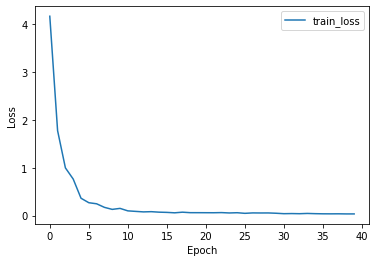

In [20]:
# Plotting Loss of Model

metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

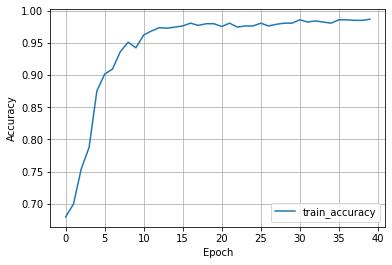

In [21]:
# Plotting Accuracy of Model

plt.plot(history.history['accuracy'], label='train_accuracy')
#plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [22]:
#!mkdir -p saved_model
model.save('/kaggle/working/saved_model')

2022-09-25 20:16:05.689880: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Reload a fresh Keras model from the saved model

In [23]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Predict Function with audio path as input

In [24]:
#Predict function with confidence level
def predict(path):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.99):
      if(indexMax==0):
        classP = 'gun_shot'
      else:
        classP = 'siren'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [25]:
#load the model
model = tf.keras.models.load_model('/kaggle/working/saved_model')

# Check its architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 41, 64)        

In [26]:
predict('../input/urbansound8k/fold7/102853-8-0-1.wav') 

[5.457772e-05 9.999454e-01]
1
Class predicted : siren 




In [27]:
predict('../input/urbansound8k/fold1/102305-6-0-0.wav') 

[0.9981901  0.00180987]
0
Class predicted : gun_shot 


